In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import pandas as pd
import json
import torch
import torchvision
from pdb import set_trace
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import subprocess
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import optuna
import pickle

/home/gridsan/jbriden/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Change the CUDA_VISIBLE_DEVICES values to numbers (the MIT supercloud uses UUIDs,
# and that raises errors with fastai's LRFinder
# See (https://forums.fast.ai/t/exception-occured-in-lrfinder-when-calling-event-after-fit/104389/8)
if torch.cuda.is_available():
    result = subprocess.check_output("nvidia-smi -L | grep -oE '[0-9]+:' | tr -d ':'", shell=True).decode("utf-8").strip()
    os.environ['CUDA_VISIBLE_DEVICES'] = result

    print(os.environ['CUDA_VISIBLE_DEVICES'])

0
1


In [3]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, d_model, nhead, num_layers, dropout):
        super(TransformerModel, self).__init__()

        self.d_model = d_model
        self.encoder = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model, nhead), num_layers)
        self.decoder = nn.Linear(d_model, output_size)

    def forward(self, src):
        # src shape: (batch_size, input_size)
        x = self.encoder(src) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x
        
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


In [4]:
# Set random seed
torch.manual_seed(42)


# Load Data

In [5]:
train_dataset_constraints = torch.load('Data/vf_0/train_dataset_constraints.pt')
test_dataset_constraints = torch.load('Data/vf_0/test_dataset_constraints.pt')

train_dataset_time = torch.load('Data/vf_0/train_dataset_time.pt')
test_dataset_time = torch.load('Data/vf_0/test_dataset_time.pt')

standardized_train_dataset_constraints = torch.load('Data/vf_0/standardized_train_dataset_constraints.pt')
standardized_test_dataset_constraints = torch.load('Data/vf_0/standardized_test_dataset_constraints.pt')

standardized_train_dataset_time = torch.load('Data/vf_0/standardized_train_dataset_time.pt')
standardized_test_dataset_time = torch.load('Data/vf_0/standardized_test_dataset_time.pt')


In [4]:
len(standardized_train_dataset_time)

193834

In [6]:
# Load mean and std values
with open('Data/vf_0/scaler_constraints.pkl', 'rb') as f:
    scaler_constraints = pickle.load(f)

mean_constraints = scaler_constraints['mean']
std_constraints = scaler_constraints['std']

with open('Data/vf_0/scaler_time.pkl', 'rb') as f:
    scaler_time = pickle.load(f)

mean_time = scaler_time['mean']
std_time = scaler_time['std']

In [13]:
mean_time

tensor(552.0598)

In [14]:
std_time

tensor(842.1304)

In [11]:
mean_constraints

tensor(552.0598)

In [12]:
std_constraints

tensor(842.1304)

# Load Model

In [6]:
transformer = torch.load('Model/transformer_model_vf_0_constraints_normalized.pt')

## Visualize Model

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import hashlib


test_dataloader = DataLoader(standardized_test_dataset_constraints, batch_size=1, shuffle=True)
num_samples = 30000  # Specify the number of samples you want
samples = []

/state/partition1/slurm_tmp/22705295.0.0/ipykernel_8899/4269093389.py:17: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  array_str = flat_array.tostring()
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Locator attempting to generate 5749 ticks ([0, ..., 5748]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5749 ticks ([0, ..., 5748]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5749 ticks ([0, ..., 5748]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 5749 ticks ([0, ..., 5748]), which exceeds Locat

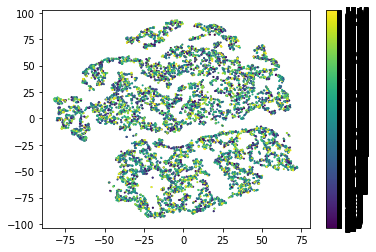

In [29]:

# Initialize lists to store the samples and the labels
samples = []
labels = []

# Loop over the dataloader to get the samples
for i, batch in enumerate(test_dataloader):
    if i >= num_samples:
        break
    x = batch[0]
    y = batch[1]  # these are your labels
    
    # Forward pass through the model up to the encoder
    with torch.no_grad():
        encoded = transformer.encoder(x).detach().numpy()
    samples.append(encoded)
    flat_array = y.numpy().flatten()
    array_str = flat_array.tostring()
    hash_value = hashlib.sha256(array_str).hexdigest()

    labels.append(hash_value)  # collect the labels as well

# Stack all samples
samples = np.vstack(samples)
#labels = np.concatenate(labels)  # concatenate all label batches

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
components = tsne.fit_transform(samples)

# Create a dictionary mapping each unique hash to a unique integer
unique_labels = np.unique(labels)
hash_to_int = {hash: i for i, hash in enumerate(unique_labels)}

# Create a new list of labels where each hash is replaced with its corresponding integer
integer_labels = [hash_to_int[hash] for hash in labels]

# Now use integer_labels as the c parameter in the scatter plot function
cmap = plt.cm.get_cmap('viridis', len(unique_labels))
plt.scatter(components[:, 0], components[:, 1], s=1, c=integer_labels, cmap=cmap)
plt.colorbar(ticks=range(len(unique_labels)))
plt.show()




In [73]:
# Initialize lists to store the samples and the labels
samples = []
labels = []

# Loop over the dataloader to get the samples
for i, batch in enumerate(test_dataloader):
    if i >= num_samples:
        break
    x = batch[0]
    y = batch[1]  # these are your labels
    
    # Forward pass through the model up to the encoder
    with torch.no_grad():
        encoded = transformer.encoder(x).detach().numpy()
    samples.append(encoded)
    flat_array = y.numpy().flatten()
    array_str = flat_array.tostring()
    hash_value = hashlib.sha256(array_str).hexdigest()

    labels.append(sum(flat_array))  # collect the labels as well

# Stack all samples
samples = np.vstack(samples)
#labels = np.concatenate(labels)  # concatenate all label batches

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
components = tsne.fit_transform(samples)


# Create a dictionary mapping each unique hash to a unique integer
label_to_int = {label: i for i, label in enumerate(np.unique(labels))}
integer_labels = [label_to_int[label] for label in labels]


/state/partition1/slurm_tmp/22705295.0.0/ipykernel_8899/1213992609.py:17: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  array_str = flat_array.tostring()
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


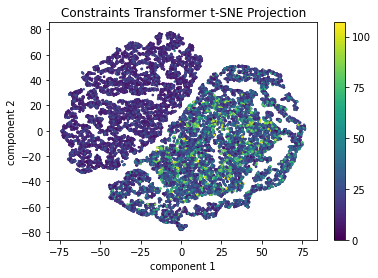

In [74]:
# Now use integer_labels as the c parameter in the scatter plot function
cmap = plt.cm.get_cmap('viridis', len(unique_labels))
plt.scatter(components[:, 0], components[:, 1], s=2, c=integer_labels, cmap=cmap)
# Choose every nth label
n = 25
selected_ticks = np.arange(0, len(unique_labels), n)

plt.colorbar(ticks=selected_ticks)
plt.title("Constraints Transformer t-SNE Projection")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.savefig('t-SNE_Constraints.png')
plt.show()

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


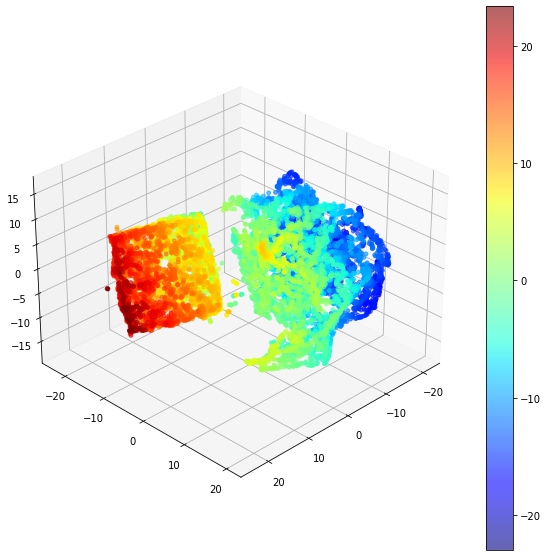

In [28]:
from mpl_toolkits.mplot3d import Axes3D

num_samples = 100  # Specify the number of samples you want
samples = []

# Loop over the dataloader to get the samples
for i, batch in enumerate(test_dataloader):
    if i >= num_samples:
        break
    x = batch[0]

    # Forward pass through the model up to the encoder
    with torch.no_grad():
        encoded = transformer.encoder(x).detach().numpy()
    samples.append(encoded)

# Stack all samples
samples = np.vstack(samples)

# Use t-SNE for dimensionality reduction to 3 components
tsne = TSNE(n_components=3)
components = tsne.fit_transform(samples)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Use a colormap (like 'jet', 'viridis', 'coolwarm', etc.)
colormap = plt.cm.jet

# Normalize to [0,1] for using the colormap
norm = plt.Normalize(components.min(), components.max())

# Scatter plot with points of size 15 and some transparency (alpha=0.6)
sc = ax.scatter(components[:, 0], components[:, 1], components[:, 2], s=15, c=components[:, 0], cmap=colormap, norm=norm, alpha=0.6)

# Add a colorbar
plt.colorbar(sc)

# Setting the viewpoint
ax.view_init(elev=30, azim=45)

plt.show()



/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


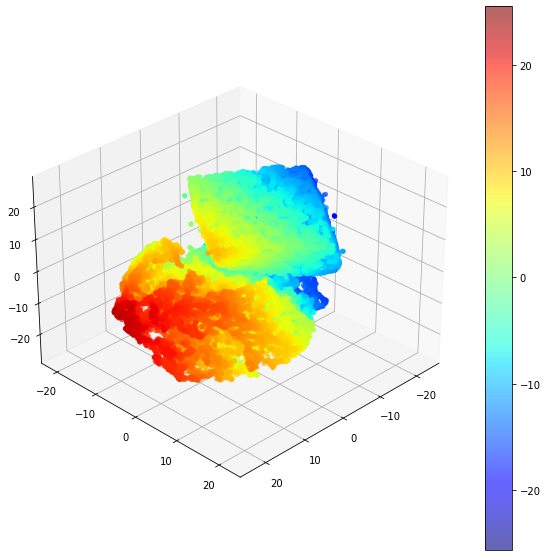

In [8]:
from mpl_toolkits.mplot3d import Axes3D

num_samples = 1000  # Specify the number of samples you want
samples = []

# Loop over the dataloader to get the samples
for i, batch in enumerate(test_dataloader):
    if i >= num_samples:
        break
    x = batch[0]

    # Forward pass through the model up to the encoder
    with torch.no_grad():
        encoded = transformer.encoder(x).detach().numpy()
    samples.append(encoded)

# Stack all samples
samples = np.vstack(samples)

# Use t-SNE for dimensionality reduction to 3 components
tsne = TSNE(n_components=3)
components = tsne.fit_transform(samples)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Use a colormap (like 'jet', 'viridis', 'coolwarm', etc.)
colormap = plt.cm.jet

# Normalize to [0,1] for using the colormap
norm = plt.Normalize(components.min(), components.max())

# Scatter plot with points of size 15 and some transparency (alpha=0.6)
sc = ax.scatter(components[:, 0], components[:, 1], components[:, 2], s=15, c=components[:, 0], cmap=colormap, norm=norm, alpha=0.6)

# Add a colorbar
plt.colorbar(sc)

# Setting the viewpoint
ax.view_init(elev=30, azim=45)

plt.show()

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


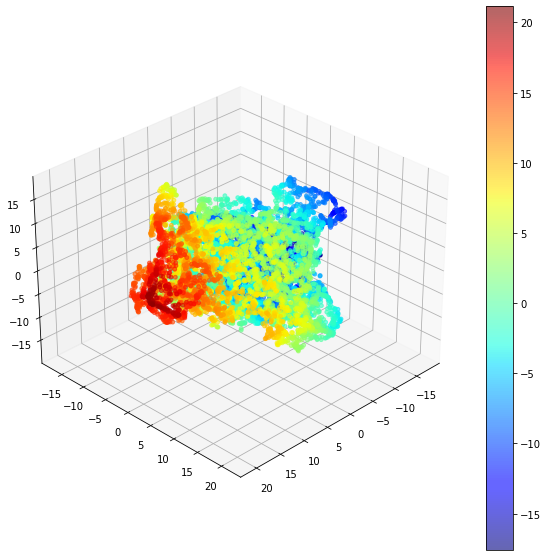

In [12]:
from mpl_toolkits.mplot3d import Axes3D

num_samples = 10000  # Specify the number of samples you want
samples = []

# Loop over the dataloader to get the samples
for i, batch in enumerate(test_dataloader):
    if i >= num_samples:
        break
    x = batch[0]

    # Forward pass through the model up to the encoder
    with torch.no_grad():
        encoded = transformer.encoder(x).detach().numpy()
    samples.append(encoded)

# Stack all samples
samples = np.vstack(samples)

# Use t-SNE for dimensionality reduction to 3 components
tsne = TSNE(n_components=3)
components = tsne.fit_transform(samples)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Use a colormap (like 'jet', 'viridis', 'coolwarm', etc.)
colormap = plt.cm.jet

# Normalize to [0,1] for using the colormap
norm = plt.Normalize(components.min(), components.max())

# Scatter plot with points of size 15 and some transparency (alpha=0.6)
sc = ax.scatter(components[:, 0], components[:, 1], components[:, 2], s=15, c=components[:, 0], cmap=colormap, norm=norm, alpha=0.6)

# Add a colorbar
plt.colorbar(sc)

# Setting the viewpoint
ax.view_init(elev=30, azim=45)

plt.show()

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import hashlib


train_dataloader = DataLoader(standardized_train_dataset_constraints, batch_size=1, shuffle=True)
num_samples = 30000  # Specify the number of samples you want
samples = []

In [11]:
# Initialize lists to store the samples and the labels
samples = []
labels = []

# Loop over the dataloader to get the samples
for i, batch in enumerate(train_dataloader):
    if i >= num_samples:
        break
    x = batch[0]
    y = batch[1]  # these are your labels
    
    # Forward pass through the model up to the encoder
    with torch.no_grad():
        encoded = transformer.encoder(x).detach().numpy()
    samples.append(encoded)
    flat_array = y.numpy().flatten()
    array_str = flat_array.tostring()
    hash_value = hashlib.sha256(array_str).hexdigest()

    labels.append(sum(flat_array))  # collect the labels as well

# Stack all samples
samples = np.vstack(samples)
#labels = np.concatenate(labels)  # concatenate all label batches

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
components = tsne.fit_transform(samples)


# Create a dictionary mapping each unique hash to a unique integer
label_to_int = {label: i for i, label in enumerate(np.unique(labels))}
integer_labels = [label_to_int[label] for label in labels]

/state/partition1/slurm_tmp/22716471.0.0/ipykernel_31608/2812456527.py:17: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  array_str = flat_array.tostring()
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


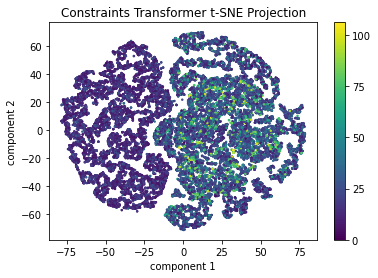

In [13]:
# Now use integer_labels as the c parameter in the scatter plot function
cmap = plt.cm.get_cmap('viridis', len(label_to_int))
plt.scatter(components[:, 0], components[:, 1], s=2, c=integer_labels, cmap=cmap)
# Choose every nth label
n = 25
selected_ticks = np.arange(0, len(label_to_int), n)

plt.colorbar(ticks=selected_ticks)
plt.title("Constraints Transformer t-SNE Projection")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.savefig('t-SNE_Constraints_train.png')
plt.show()

# Load Model

In [14]:
transformer = torch.load('Model/transformer_model_vf_0_time_normalized.pt')

# Visualize Model

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import hashlib


test_dataloader = DataLoader(standardized_test_dataset_time, batch_size=1, shuffle=True)
num_samples = 30000  # Specify the number of samples you want
samples = []

In [ ]:
# Initialize lists to store the samples and the labels
samples = []
labels = []

# Loop over the dataloader to get the samples
for i, batch in enumerate(test_dataloader):
    if i >= num_samples:
        break
    x = batch[0]
    y = batch[1]  # these are your labels
    
    # Forward pass through the model up to the encoder
    with torch.no_grad():
        encoded = transformer.encoder(x).detach().numpy()
    samples.append(encoded)

    labels.append(y.numpy().flatten())  # collect the labels as well

# Stack all samples
samples = np.vstack(samples)
#labels = np.concatenate(labels)  # concatenate all label batches

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
components = tsne.fit_transform(samples)






In [66]:
# Create a dictionary mapping each unique hash to a unique integer
label_to_int = {label: i for i, label in enumerate(np.unique(labels))}
integer_labels = [round(label[0]) for label in labels]

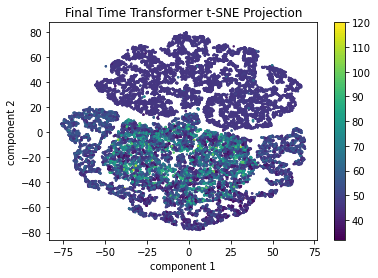

In [67]:
# Now use integer_labels as the c parameter in the scatter plot function
cmap = plt.cm.get_cmap('viridis', len(unique_labels))
plt.scatter(components[:, 0], components[:, 1], s=2, c=integer_labels, cmap=cmap)
# Choose every nth label
n = 25
selected_ticks = np.arange(0, len(unique_labels))

plt.colorbar()
plt.title("Final Time Transformer t-SNE Projection")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.savefig('t-SNE_Time.png')
plt.show()

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import hashlib


train_dataloader = DataLoader(standardized_train_dataset_time, batch_size=1, shuffle=True)
num_samples = 30000  # Specify the number of samples you want
samples = []

In [17]:
# Initialize lists to store the samples and the labels
samples = []
labels = []

# Loop over the dataloader to get the samples
for i, batch in enumerate(train_dataloader):
    if i >= num_samples:
        break
    x = batch[0]
    y = batch[1]  # these are your labels
    
    # Forward pass through the model up to the encoder
    with torch.no_grad():
        encoded = transformer.encoder(x).detach().numpy()
    samples.append(encoded)

    labels.append(y.numpy().flatten())  # collect the labels as well

# Stack all samples
samples = np.vstack(samples)
#labels = np.concatenate(labels)  # concatenate all label batches

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
components = tsne.fit_transform(samples)

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [18]:
# Create a dictionary mapping each unique hash to a unique integer
label_to_int = {label: i for i, label in enumerate(np.unique(labels))}
integer_labels = [round(label[0]) for label in labels]

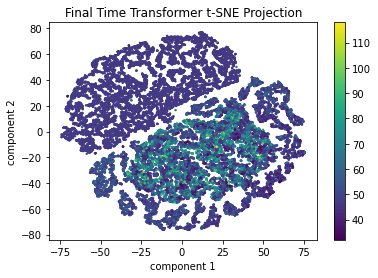

In [20]:
# Now use integer_labels as the c parameter in the scatter plot function
cmap = plt.cm.get_cmap('viridis', len(np.unique(labels)))
plt.scatter(components[:, 0], components[:, 1], s=2, c=integer_labels, cmap=cmap)
# Choose every nth label
n = 25
selected_ticks = np.arange(0, len(np.unique(labels)))

plt.colorbar()
plt.title("Final Time Transformer t-SNE Projection")
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.savefig('t-SNE_Time_train.png')
plt.show()

# Test Evaluation

In [49]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
inputs, labels = next(iter(test_dataloader))
with torch.no_grad():
        outputs = transformer(inputs)
abs(torch.round(labels)-torch.round(outputs))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

# Generate a New Dataset

In [7]:
import pandas as pd
df1 = pd.read_csv("./Sampling/65k_20deg500pos200vel_0rf.csv")
df2 = pd.read_csv("./Sampling/80k_20deg1000pos100vel_0rf.csv")
df3 = pd.read_csv("./Sampling/95k_10deg100pos10vel_0rf.csv")

df = pd.concat([df1,df2,df3])

df.keys()

Index(['Theta', 'Phi', 'Gamma_gs', 'Gamma_p', 'R_0_x', 'R_0_y', 'R_0_z',
       'R_f_x', 'R_f_y', 'R_f_z', 'V_0_x', 'V_0_y', 'V_0_z', 'Final Time',
       'Velocity Upper Bound', 'Glideslope', 'Thrust Bound (x)',
       'Thrust Bound (y)', 'Thrust Bound (z)', 'Mass Bound 1', 'Mass Bound 2',
       'Attitude Pointing Bound', 'Boundary Conditions'],
      dtype='object')

In [8]:
from ast import literal_eval
# Using DataFrame.loc[] create new DataFrame by specific column.
df_theta=df.loc[:, df.columns.drop(['Theta','Final Time','Velocity Upper Bound', 'Glideslope', 'Thrust Bound (x)',
       'Thrust Bound (y)', 'Thrust Bound (z)', 'Mass Bound 1', 'Mass Bound 2',
       'Attitude Pointing Bound', 'Boundary Conditions','R_f_x', 'R_f_y', 'R_f_z'])]
df_theta.astype(float)

x = torch.tensor(df_theta.values, dtype=torch.float32)

df_strategy=df.loc[:, df.columns.drop(['Theta','Phi', 'Gamma_gs', 'Gamma_p', 'R_0_x', 'R_0_y', 'R_0_z',
       'R_f_x', 'R_f_y', 'R_f_z', 'V_0_x', 'V_0_y', 'V_0_z'])]

# Assuming df is your DataFrame
columns_to_convert = ['Velocity Upper Bound', 'Glideslope', 'Thrust Bound (x)', 'Thrust Bound (y)', 'Thrust Bound (z)', 'Mass Bound 1', 'Mass Bound 2','Attitude Pointing Bound']

# Apply ast.literal_eval to all elements in the specified columns
df_strategy[columns_to_convert] = df_strategy[columns_to_convert].applymap(literal_eval)

# Function to convert values to float
def convert_to_float(value):
    if isinstance(value, list):
        return [float(x) for x in value]
    else:
        return float(value)

# Apply the function to the entire DataFrame
df_strategy_float = df_strategy.applymap(convert_to_float)


# Function to concatenate lists in a row
def concat_lists(row):
    concatenated_row = []
    for col in df_strategy_float.columns:
        if isinstance(row[col], list):
            concatenated_row.extend(row[col])
        else:
            concatenated_row.append(row[col])
    return pd.Series(concatenated_row)

# Apply the function to each row of the DataFrame
df_concatenated = df_strategy_float.apply(concat_lists, axis=1)

# Convert the concatenated DataFrame to a PyTorch tensor
y = torch.tensor(df_concatenated.values, dtype=torch.float32)


In [9]:
df_theta

,Phi,Gamma_gs,Gamma_p,R_0_x,R_0_y,R_0_z,V_0_x,V_0_y,V_0_z
0,0.274718,1.335449,0.927858,2192.935423,1889.074048,982.147820,21.105648,-7.718199,-13.898283
1,0.349021,1.514006,1.193987,1956.873744,1766.881367,989.481106,61.153364,-92.845540,19.038281
2,0.201225,1.370615,1.116969,1903.338422,1875.932984,863.737585,-18.017941,34.114867,-17.588536
3,0.222595,1.310938,1.001752,1868.409569,1802.358981,1170.804305,-108.238282,66.585362,36.890826
4,0.096523,1.341441,0.873380,1830.954304,1923.620062,1129.807916,79.622788,83.803491,48.440267
...,...,...,...,...,...,...,...,...,...
94681,0.116728,1.410966,1.112505,1996.585868,2026.363298,974.102823,-19.127906,-11.304721,-30.382406
94682,0.099822,1.406600,0.987955,1950.911014,1978.871951,1015.912497,-18.808947,-18.287336,-33.987427
94683,0.256726,1.398224,1.060756,1991.419212,2033.818228,951.321582,-16.498529,-15.912173,-31.013113
94684,0.223226,1.318654,1.100787,1959.212111,2019.766331,1028.476670,-18.273804,-10.300893,-33.497925


In [10]:
df_strategy

,Final Time,Velocity Upper Bound,Glideslope,Thrust Bound (x),Thrust Bound (y),Thrust Bound (z),Mass Bound 1,Mass Bound 2,Attitude Pointing Bound,Boundary Conditions
0,54.122736,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0
1,60.374603,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0
2,51.118522,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
3,84.110039,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0
4,112.626236,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0
...,...,...,...,...,...,...,...,...,...,...
94681,46.611856,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
94682,45.379902,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
94683,46.683305,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
94684,46.761689,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [11]:
print("Range of Phi: [", min(df_theta["Phi"]*180/np.pi)," deg, ", max(df_theta["Phi"]*180/np.pi)," deg]")
print("Range of Gamma_gs: [", min(df_theta["Gamma_gs"]*180/np.pi)," deg, ", max(df_theta["Gamma_gs"]*180/np.pi)," deg]")
print("Range of Gamma_p: [", min(df_theta["Gamma_p"]*180/np.pi)," deg, ", max(df_theta["Gamma_p"]*180/np.pi)," deg]")
print("Range of R_0_x: [", min(df_theta["R_0_x"]),", ", max(df_theta["R_0_x"]),"]")
print("Range of R_0_y: [", min(df_theta["R_0_y"]),", ", max(df_theta["R_0_y"]),"]")
print("Range of R_0_z: [", min(df_theta["R_0_z"]),", ", max(df_theta["R_0_z"]),"]")
print("Range of V_0_x: [", min(df_theta["V_0_x"]),", ", max(df_theta["V_0_x"]),"]")
print("Range of V_0_y: [", min(df_theta["V_0_y"]),", ", max(df_theta["V_0_y"]),"]")
print("Range of V_0_z: [", min(df_theta["V_0_z"]),", ", max(df_theta["V_0_z"]),"]")
print("Range of Final Time: [", min(df_strategy["Final Time"]),", ", max(df_strategy["Final Time"]),"]")

Range of Phi: [ 0.00016551817519940666  deg,  19.999849886432525  deg]
Range of Gamma_gs: [ 70.00003151402069  deg,  89.99974508631638  deg]
Range of Gamma_p: [ 50.000041662448695  deg,  69.99993574645224  deg]
Range of R_0_x: [ 1500.0037724247152 ,  2499.9928586461665 ]
Range of R_0_y: [ 1500.0192193009034 ,  2499.988780977193 ]
Range of R_0_z: [ 500.0466269613699 ,  1499.9974333833666 ]
Range of V_0_x: [ -114.99836459207587 ,  84.99278476568162 ]
Range of V_0_y: [ -114.99712978752204 ,  84.999870151685 ]
Range of V_0_z: [ -101.73782728249182 ,  69.99200213772093 ]
Range of Final Time: [ 31.041281523335503 ,  120.91858969236758 ]


In [12]:
# Create the dataset
n = x.shape[0]
print('Dataset size: ',n)

Dataset size:  242293


In [13]:
y_time = y[:,0]
y_constraints = y[:,1:]

In [14]:
y_time

tensor([54.1227, 60.3746, 51.1185,  ..., 46.6833, 46.7617, 46.6710])

In [15]:
y_constraints

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [16]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# Assuming x is your data and y_constraints and y_time are your targets
x_constraints_train, x_constraints_test, y_constraints_train, y_constraints_test = train_test_split(x, y_constraints, test_size=0.2, random_state=42)
x_time_train, x_time_test, y_time_train, y_time_test = train_test_split(x, y_time, test_size=0.2, random_state=42)

# Calculate the mean and standard deviation of your features for constraints
mean_constraints = torch.mean(x_constraints_train)
std_constraints = torch.std(x_constraints_train)

# Standardize your features
standardized_x_constraints_train = (x_constraints_train - mean_constraints) / std_constraints
standardized_x_constraints_test = (x_constraints_test - mean_constraints) / std_constraints

# Calculate the mean and standard deviation of your features for time
mean_time = torch.mean(x_time_train)
std_time = torch.std(x_time_train)

# Standardize your features
standardized_x_time_train = (x_time_train - mean_time) / std_time
standardized_x_time_test = (x_time_test - mean_time) / std_time


In [38]:
# Now you can create a new TensorDataset with the standardized features
standardized_train_dataset_constraints = TensorDataset(standardized_x_constraints_train, y_constraints_train)
standardized_test_dataset_constraints = TensorDataset(standardized_x_constraints_test, y_constraints_test)

train_dataset_constraints = TensorDataset(x_constraints_train, y_constraints_train)
test_dataset_constraints = TensorDataset(x_constraints_test, y_constraints_test)

standardized_train_dataset_time = TensorDataset(standardized_x_time_train, y_time_train)
standardized_test_dataset_time = TensorDataset(standardized_x_time_test, y_time_test)

train_dataset_time = TensorDataset(x_time_train, y_time_train)
train_dataset_time = TensorDataset(x_time_test, y_time_test)

## Save dataset

In [40]:
torch.save(train_dataset_constraints, 'Data/vf_0/train_dataset_constraints.pt')
torch.save(test_dataset_constraints, 'Data/vf_0/test_dataset_constraints.pt')
torch.save(standardized_train_dataset_constraints, 'Data/vf_0/standardized_train_dataset_constraints.pt')
torch.save(standardized_test_dataset_constraints, 'Data/vf_0/standardized_test_dataset_constraints.pt')

torch.save(train_dataset_time, 'Data/vf_0/train_dataset_time.pt')
torch.save(test_dataset_time, 'Data/vf_0/test_dataset_time.pt')
torch.save(standardized_train_dataset_time, 'Data/vf_0/standardized_train_dataset_time.pt')
torch.save(standardized_test_dataset_time, 'Data/vf_0/standardized_test_dataset_time.pt')

In [32]:
import pickle

# Save mean and std values
scaler_constraints = {'mean': mean_constraints, 'std': std_constraints}
scaler_time = {'mean': mean_time, 'std': std_time}

with open('Data/vf_0/scaler_constraints.pkl', 'wb') as f:
    pickle.dump(scaler_constraints, f)
    
with open('Data/vf_0/scaler_time.pkl', 'wb') as f:
    pickle.dump(scaler_time, f)

# Create new NN

## Constraints NN

In [43]:

# Define hyperparameters
N = 50
input_size = 9
output_size = 8*N-3
d_model = 384
nhead = 2
num_layers = 4    # more layers might be needed for complex tasks
dropout = 0.1     # a common dropout rate for Transformer models

# Instantiate the model
constraintsTransformer = TransformerModel(input_size=input_size,
                               output_size=output_size,
                               d_model=d_model,
                               nhead=nhead, num_layers=num_layers, dropout=dropout)


In [44]:
print(constraintsTransformer)

TransformerModel(
  (encoder): Linear(in_features=9, out_features=384, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
        )
        (linear1): Linear(in_features=384, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=384, bias=True)
        (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinea

In [45]:


total_params = sum(
	param.numel() for param in constraintsTransformer.parameters()
)

total_params

8829453

In [63]:
from torch.utils.tensorboard import SummaryWriter

# Assuming that you have the model defined and it's called 'model'
writer = SummaryWriter()
writer.add_graph(transformer, inputs)
writer.close()

In [61]:
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

## Time NN

In [9]:
# Define hyperparameters
N = 50
input_size = 9
output_size = 1
d_model = 64
nhead = 1
num_layers = 2    # more layers might be needed for complex tasks
dropout = 0.1     # a common dropout rate for Transformer models

# Instantiate the model
timeTransformer = TransformerModel(input_size=input_size,
                               output_size=output_size,
                               d_model=d_model,
                               nhead=nhead, num_layers=num_layers, dropout=dropout)



In [10]:
print(timeTransformer)

TransformerModel(
  (encoder): Linear(in_features=9, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_fe

In [11]:


total_params = sum(
	param.numel() for param in timeTransformer.parameters()
)

total_params

563009

# Training

## Constraints NN

In [8]:
#transformer = constraintsTransformer
train_dataset = standardized_train_dataset_constraints
test_dataset = standardized_test_dataset_constraints


Fold: 1
[epoch = 1, i =     1] loss: 0.601
Validation Loss: 0.049


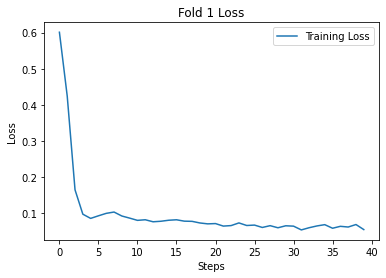

Fold: 2
[epoch = 1, i =     1] loss: 0.063
Validation Loss: 0.049


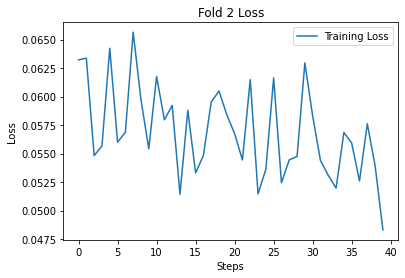

In [47]:
# Create the dataloader
batch_size = 128
learning_rate = 0.001

# Define the loss function and optimizer
criterion = nn.MSELoss()
#criterion = CustomLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate)

warmup_steps = 4000  # define the number of warmup steps

# Train the model
num_epochs = 1
num_splits = 2
kf = KFold(n_splits=num_splits)

train_dataset = Subset(train_dataset, indices=range(0, 10000))  # Use the first 100 samples


# Loop over the k-fold splits
for fold, (train_idx, valid_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")
    train_data = torch.utils.data.Subset(train_dataset, train_idx)
    valid_data = torch.utils.data.Subset(train_dataset, valid_idx)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
    loss_values = []
    valid_loss_values = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        valid_running_loss = 0.0

        # Train on the training set
        transformer.train()
        for i, batch in enumerate(train_dataloader):
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = transformer(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            avg_loss = running_loss
            loss_values.append(avg_loss)
            running_loss = 0.0

            if (i) % 100 == 0:
                print('[epoch = %d, i = %5d] loss: %.3f' % (epoch + 1, i + 1, avg_loss))                

        # Validate on the validation set
        transformer.eval()
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):
                inputs, labels = batch
                outputs = transformer(inputs)
                valid_loss = criterion(outputs.squeeze(), labels.squeeze())
                valid_running_loss += valid_loss.item()

            avg_valid_loss = valid_running_loss / len(valid_dataloader)
            valid_loss_values.append(avg_valid_loss)
            print(f"Validation Loss: {avg_valid_loss:.3f}")

    # Plot the loss values
    plt.plot(loss_values, label="Training Loss")
    #plt.plot(valid_loss_values, label="Validation Loss")
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title(f"Fold {fold + 1} Loss")
    plt.legend()
    plt.show()

## Time NN

In [10]:
transformer = timeTransformer
train_dataset = standardized_train_dataset_time
test_dataset = standardized_test_dataset_time

In [11]:
from torch.optim.lr_scheduler import LambdaLR


Fold: 1
[epoch = 1, i =     1] loss: 2714.249
[epoch = 1, i =   101] loss: 2171.092
[epoch = 1, i =   201] loss: 1970.658
[epoch = 1, i =   301] loss: 1394.404
[epoch = 1, i =   401] loss: 698.627
Validation Loss: 672.416
[epoch = 2, i =     1] loss: 655.626
[epoch = 2, i =   101] loss: 234.708
[epoch = 2, i =   201] loss: 119.717
[epoch = 2, i =   301] loss: 123.694
[epoch = 2, i =   401] loss: 165.050
Validation Loss: 105.220
[epoch = 3, i =     1] loss: 90.746
[epoch = 3, i =   101] loss: 101.887
[epoch = 3, i =   201] loss: 96.979
[epoch = 3, i =   301] loss: 93.481
[epoch = 3, i =   401] loss: 120.516
Validation Loss: 105.379


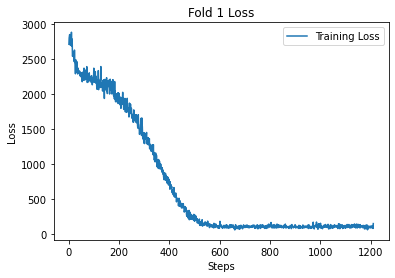

Fold: 2
[epoch = 1, i =     1] loss: 121.139
[epoch = 1, i =   101] loss: 86.745
[epoch = 1, i =   201] loss: 101.802
[epoch = 1, i =   301] loss: 120.922
[epoch = 1, i =   401] loss: 116.040
Validation Loss: 106.549
[epoch = 2, i =     1] loss: 78.573
[epoch = 2, i =   101] loss: 86.607
[epoch = 2, i =   201] loss: 91.204
[epoch = 2, i =   301] loss: 98.060
[epoch = 2, i =   401] loss: 101.533
Validation Loss: 106.721
[epoch = 3, i =     1] loss: 102.161
[epoch = 3, i =   101] loss: 107.990


KeyboardInterrupt: 

In [12]:
# Create the dataloader
batch_size = 64*5
learning_rate = 0.01

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate)
warmup_steps = 4000  # define the number of warmup steps


def lr_lambda(current_step):
    if current_step < warmup_steps:
        return current_step / warmup_steps
    elif current_step == warmup_steps:
        return 0.01
    return 0.01 * (current_step - warmup_steps) ** -0.5

# `optimizer` is the optimizer for your model
scheduler = LambdaLR(optimizer, lr_lambda)

# Train the model
num_epochs = 3
num_splits = 3
kf = KFold(n_splits=num_splits)

#train_dataset = Subset(train_dataset, indices=range(1, 40000))  # Use the first 100 samples


# Loop over the k-fold splits
for fold, (train_idx, valid_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")
    train_data = torch.utils.data.Subset(train_dataset, train_idx)
    valid_data = torch.utils.data.Subset(train_dataset, valid_idx)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
    loss_values = []
    valid_loss_values = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        valid_running_loss = 0.0

        # Train on the training set
        transformer.train()
        for i, batch in enumerate(train_dataloader):
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = transformer(inputs)
            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
            
            # Step the scheduler
            scheduler.step()
            
            running_loss += loss.item()
            
            avg_loss = running_loss
            loss_values.append(avg_loss)
            running_loss = 0.0

            if (i) % 100 == 0:
                print('[epoch = %d, i = %5d] loss: %.3f' % (epoch + 1, i + 1, avg_loss))                

        # Validate on the validation set
        transformer.eval()
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):
                inputs, labels = batch
                outputs = transformer(inputs)
                valid_loss = criterion(outputs.squeeze(), labels.squeeze())
                valid_running_loss += valid_loss.item()

            avg_valid_loss = valid_running_loss / len(valid_dataloader)
            valid_loss_values.append(avg_valid_loss)
            print(f"Validation Loss: {avg_valid_loss:.3f}")

    # Plot the loss values
    plt.plot(loss_values, label="Training Loss")
    #plt.plot(valid_loss_values, label="Validation Loss")
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title(f"Fold {fold + 1} Loss")
    plt.legend()
    plt.show()


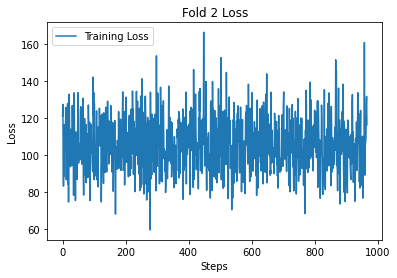

In [13]:
    # Plot the loss values
    plt.plot(loss_values, label="Training Loss")
    #plt.plot(valid_loss_values, label="Validation Loss")
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title(f"Fold {fold + 1} Loss")
    plt.legend()
    plt.show()

# Testing

## Constraints NN

In [9]:
# Initialize counters
total = 0
binary_correct = 0
mse_sum = 0

# Set the batch size for evaluation
batch_size = 1

# Create a DataLoader for the test dataset with the new batch size
#test_data_small = Subset(test_dataset, indices=range(0, 20000))  # Use the first 100 samples
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# No gradient needed for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        # Get the inputs and labels for the current batch
        inputs, labels = batch

        # Forward pass
        outputs = transformer(inputs)

        # Update the count of correct predictions and total examples for binary part
        total += labels.numel()
        binary_correct += (torch.round(outputs) == labels).sum().item()

# Calculate final metrics
binary_accuracy = 100 * binary_correct / total

# Print the metrics
print(f'Binary accuracy on test set: {binary_accuracy:.2f} %')

Binary accuracy on test set: 94.01 %


In [50]:
    # Get the inputs and labels for the current batch
    inputs, labels = batch

    # Forward pass
    outputs = transformer(inputs)

    # Split your output and labels into binary and continuous parts
    binary_outputs = outputs
    print(abs(torch.round(binary_outputs)))
    binary_labels = labels
    print(binary_labels)

    # Update the count of correct predictions and total examples for binary part
    total += binary_labels.numel()
    binary_correct += (torch.round(binary_outputs) == binary_labels).sum().item()
    print(binary_correct)


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.,

## Timing test for evaluation

In [51]:
import time

elapsed_times = []  # Add this line to store elapsed times

for i in range(100):
    start = time.time()
    # Forward pass
    outputs = transformer(inputs)
    elapsed_times.append(time.time() - start)
average_elapsed_time = sum(elapsed_times) / len(elapsed_times)
print("Average elapsed time for each iteration: {:.1f} ms".format(average_elapsed_time*1e3))

Average elapsed time for each iteration: 2.7 ms


In [52]:
torch.save(transformer, 'Model/transformer_model_vf_0_constraints_normalized.pt')

# Time NN

In [19]:
# Initialize counters
total = 0
binary_correct = 0
mse_sum = 0

# Set the batch size for evaluation
batch_size = 1

# Create a DataLoader for the test dataset with the new batch size
#test_data_small = Subset(test_dataset, indices=range(0, 10000))  # Use the first 100 samples
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# No gradient needed for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        # Get the inputs and labels for the current batch
        inputs, labels = batch

        # Forward pass
        outputs = transformer(inputs)

        total += labels.numel()

        # Calculate MSE for continuous part and add it to the running total
        mse_sum += ((outputs - labels) ** 2).sum().item()

# Calculate final metrics
continuous_mse = mse_sum / total  # Note: this is MSE over all continuous samples

# Print the metrics
print(f'Continuous MSE on test set: {continuous_mse:.4f}')

Continuous MSE on test set: 104.2582


In [20]:
print(outputs)
print(labels)

tensor([[51.5860]])
tensor([44.7925])


In [21]:
torch.save(transformer, 'Model/transformer_model_vf_0_time_normalized.pt')

## Timing test for evaluation

In [46]:
import time

elapsed_times = []  # Add this line to store elapsed times

for i in range(100):
    start = time.time()
    # Forward pass
    outputs = transformer(inputs)
    elapsed_times.append(time.time() - start)
average_elapsed_time = sum(elapsed_times) / len(elapsed_times)
print("Average elapsed time for each iteration: {:.1f} ms".format(average_elapsed_time*1e3))

Average elapsed time for each iteration: 2.1 ms
